In [1]:
import os
import re
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt

In [2]:
last_rundir = sorted(os.listdir('runinfo'))[-1]

logdata = None
with open("runinfo/{}/parsl.log".format(last_rundir)) as f:
    logdata = f.readlines()

In [7]:
tasks = {}
termination_time = None
for item in logdata:
    if "Task " in item:        
        t = datetime.strptime(item[:23], '%Y-%m-%d %H:%M:%S.%f')
        task_id = item.split("Task")[1].split()[0]
        if task_id not in tasks:
            tasks[task_id] = {'submitted':None,
                              'set':None, # Pending
                              'launched':None,
                              'failed':None,
                              'marked':None,
                              'completed':None
                             }        
        
        flag = False
        for kind in ["submitted", "set", "launched", "failed", "marked", "completed"]:
            if kind in item:
                tasks[task_id][kind] = t
                flag = True
        if not flag:
            print(item)
    
    if "Terminating job" in item:
        if not termination_time:
            termination_time = t

In [8]:
print(tasks)

{'0': {'submitted': datetime.datetime(2019, 4, 8, 12, 31, 41, 817000), 'set': datetime.datetime(2019, 4, 8, 12, 31, 41, 818000), 'launched': datetime.datetime(2019, 4, 8, 12, 31, 44, 923000), 'failed': datetime.datetime(2019, 4, 8, 12, 31, 44, 916000), 'marked': datetime.datetime(2019, 4, 8, 12, 31, 44, 920000), 'completed': datetime.datetime(2019, 4, 8, 12, 31, 53, 913000)}, '1': {'submitted': datetime.datetime(2019, 4, 8, 12, 31, 41, 823000), 'set': datetime.datetime(2019, 4, 8, 12, 31, 41, 823000), 'launched': datetime.datetime(2019, 4, 8, 12, 31, 44, 927000), 'failed': datetime.datetime(2019, 4, 8, 12, 31, 44, 924000), 'marked': datetime.datetime(2019, 4, 8, 12, 31, 44, 925000), 'completed': datetime.datetime(2019, 4, 8, 12, 31, 58, 241000)}, '2': {'submitted': datetime.datetime(2019, 4, 8, 12, 31, 41, 827000), 'set': datetime.datetime(2019, 4, 8, 12, 31, 41, 828000), 'launched': datetime.datetime(2019, 4, 8, 12, 31, 41, 846000), 'failed': None, 'marked': None, 'completed': datetim

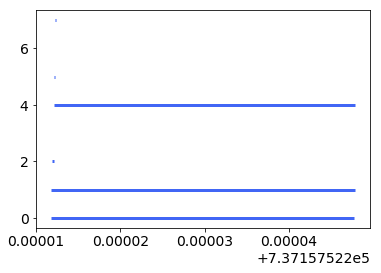

In [10]:
font = {#'family' : 'normal',                                                                                                                                                                                                              
        #'weight' : 'bold',                                                                                                                                                                                                                    
            'size'   : 14}

matplotlib.rc('font', **font)

f, jobs    = plt.subplots(1, sharex=True)
# plt.legend(loc=0, ncol=2,  fancybox=1, framealpha=0.8)
launched     = jobs.hlines(range(0, len(tasks)) ,
                           [tasks[x]['submitted'] for x in tasks],
                           [tasks[x]['launched'] for x in tasks],
                           label='Submitted',
                           colors='#4166f5',
                           antialiased=True,
                           linewidth=3.0)

running     = jobs.hlines(range(0, len(tasks)) ,
                         [tasks[x]['submitted'] for x in tasks],
                         [tasks[x]['launched'] for x in tasks],
                         label='Submitted',
                         colors='#4166f5',
                         antialiased=True,
                         linewidth=3.0)



In [ ]:
for x in tasks:
    print(tasks[x]['submitted'])